In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [32]:
from __future__ import division

import numpy as np
import scipy.stats as st
import pymc as pm
import pymc3 as pm3
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import re
import os
import sys
import string
import pprint
import itertools
import functools


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
sns.set()

In [4]:
#dir_in = ...
#dir_out = ...

In [1]:
# S&P 500 data downloaded from:
# http://finance.yahoo.com/q/hp?s=%5EGSPC+Historical+Prices

###Load S&P 500 Daily Diffs

In [6]:
d_diff = pd.read_csv(os.path.join(dir_out, "SnP_500.diff.csv"), parse_dates=[0]).set_index("Date").sort_index()
d_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16426 entries, 1950-01-05 to 2015-04-17
Data columns (total 8 columns):
diff_price             16426 non-null float64
abs_diff_price         16426 non-null float64
diff_volume            16426 non-null float64
abs_diff_volume        16426 non-null float64
diff_price_lag         16426 non-null float64
abs_diff_price_lag     16426 non-null float64
diff_volume_lag        16426 non-null float64
abs_diff_volume_lag    16426 non-null float64
dtypes: float64(8)
memory usage: 1.1 MB


###Look at price diffs

In [11]:
t_params_price = st.t.fit(d_diff.diff_price)
t_params_price

(3.1564733375757523, 0.00047152083562035688, 0.0061046682229896794)

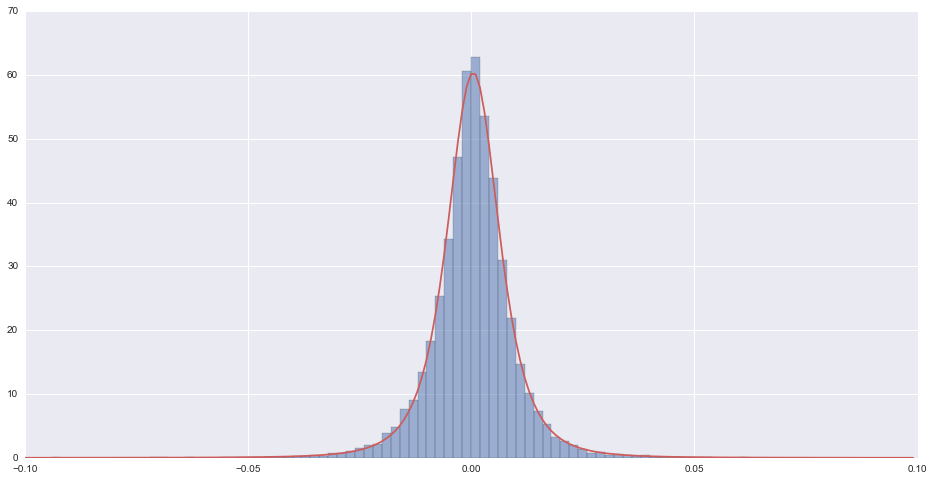

In [149]:
x = np.arange(-0.1, 0.1, 0.001)
_ = hist(d_diff.diff_price, normed=True, bins=x[::2], alpha=0.5)
_ = plot(x, st.t.pdf(x, *t_params_price), "indianred")

In [147]:
exp_params_abs_price = st.expon.fit(d_diff.abs_diff_price)
exp_params_abs_price

(-5.1131837207468998e-12, 0.0065536001269847176)

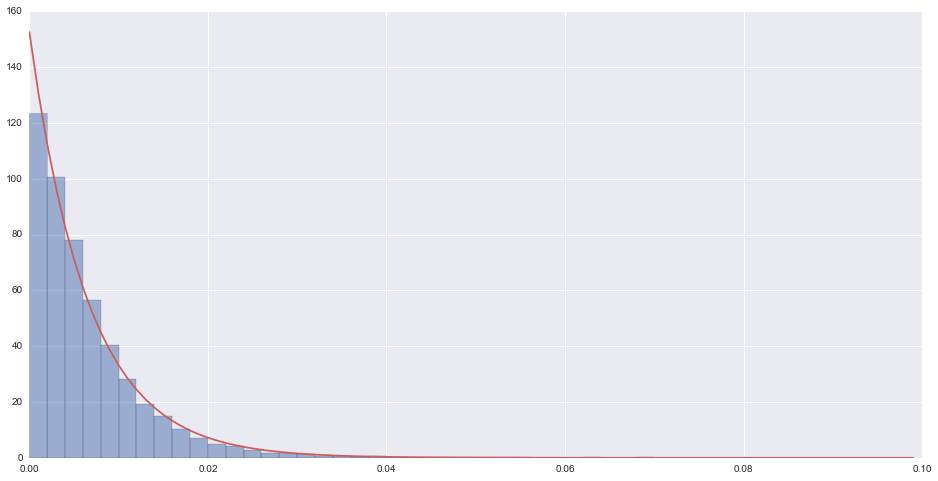

In [148]:
x = np.arange(0.0, 0.1, 0.001)
_ = hist(d_diff.abs_diff_price, normed=True, bins=x[::2], alpha=0.5)
_ = plot(x, st.expon.pdf(x, *exp_params_abs_price), "indianred")

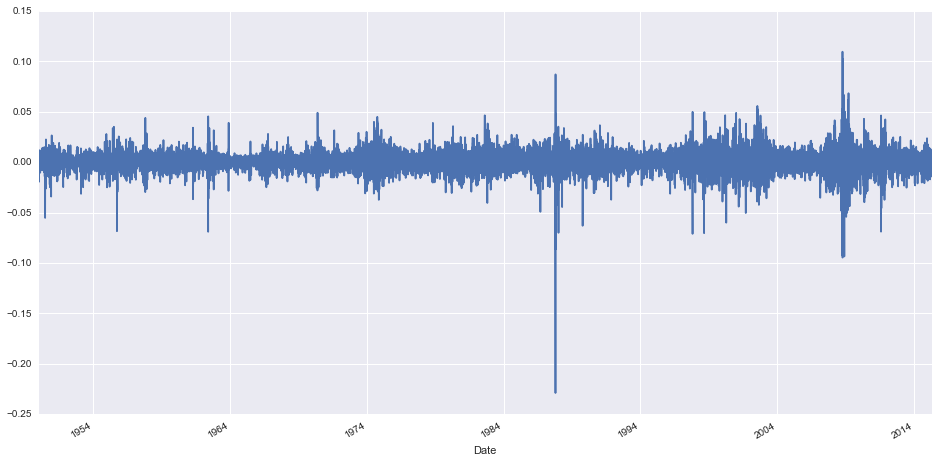

In [150]:
d_diff.diff_price.plot()

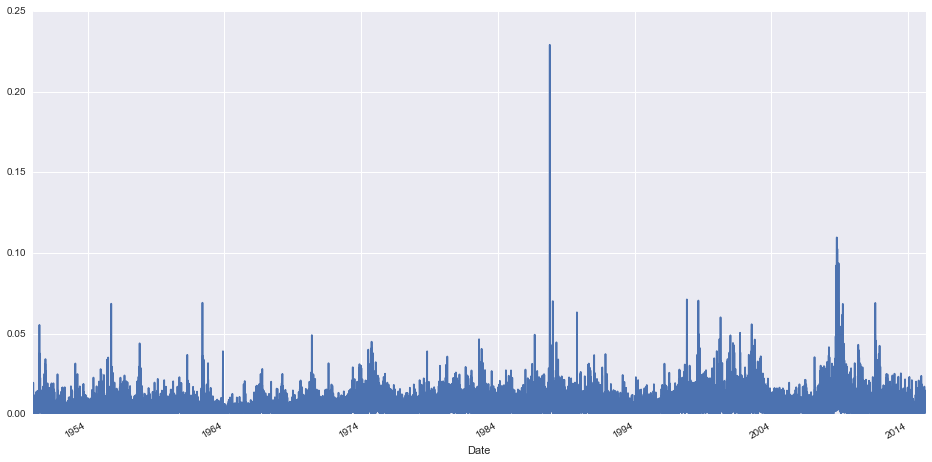

In [151]:
d_diff.abs_diff_price.plot()

###Build and fit a stochastic volatility model

In [2]:
# Based on:
# http://nbviewer.ipython.org/github/pymc-devs/pymc3/blob/master/pymc3/examples/stochastic_volatility.ipynb
# http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf

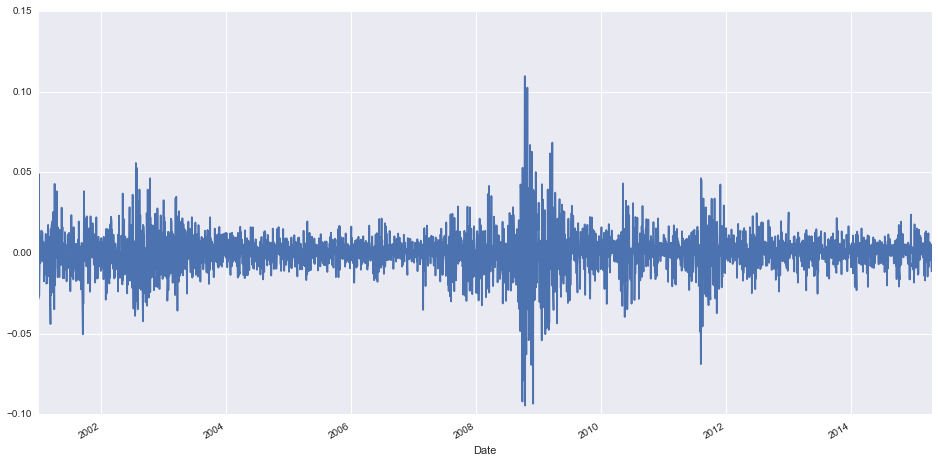

In [104]:
s_diff_price = d_diff.diff_price[d_diff.index.year > 2000]
s_diff_price.plot(figsize=(16, 8))

In [49]:
n = len(s_diff_price)
n

3594

In [54]:
from pymc3.distributions.timeseries import GaussianRandomWalk
from scipy import optimize

In [53]:
sv_model = pm3.Model()
with sv_model:

    lambda_prior_sigma = 1.0 / 0.02
    lambda_prior_nu = 1.0 / 10.0
    
    sigma, log_sigma = sv_model.TransformedVar('sigma',
                                               pm3.Exponential.dist(lambda_prior_sigma, testval=0.1),
                                               pm3.logtransform)
    nu = pm3.Exponential('nu', lambda_prior_nu)
    s = GaussianRandomWalk('s', sigma**-2, shape=n)

    r = pm3.T('r', nu, lam=pm3.exp(-2*s), observed=s_diff_price.values)

In [55]:
with sv_model:
    start = pm3.find_MAP(vars=[s], fmin=optimize.fmin_l_bfgs_b)

In [63]:
start

{'log_sigma': array(-2.3025850929940455),
 'nu': array(6.931471824645996),
 's': array([-4.17040811, -4.1864827 , -4.24006796, ..., -5.19596782,
        -5.18681349, -5.16786236])}

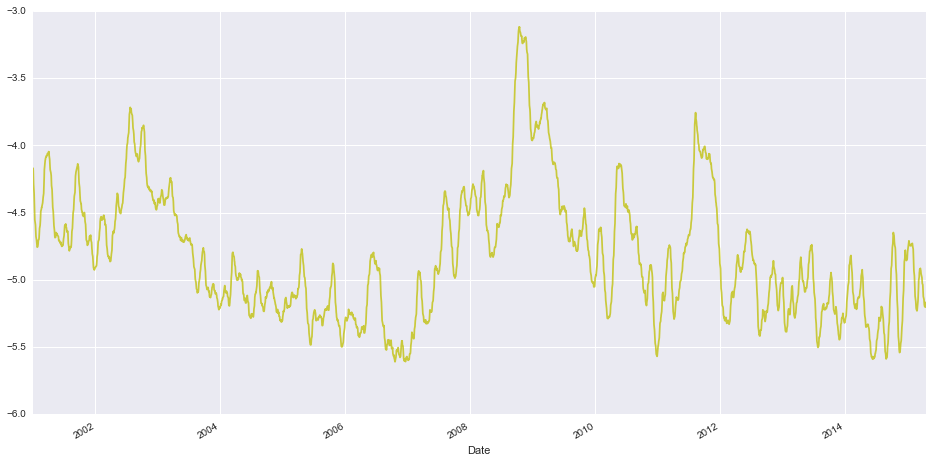

In [117]:
pd.Series(index=s_diff_price.index, data=start["s"]).plot(figsize=(16, 8), color="y", alpha=0.75)

In [65]:
with sv_model:
    step = pm3.NUTS(scaling=start)
    start2 = pm3.sample(500, step, progressbar=False)[-1]

    # Start next run at the last sampled position.
    step = pm3.NUTS(scaling=start2)
    trace = pm3.sample(2000, step, start=start2, progressbar=True)

 [-----------------100%-----------------] 2001 of 2000 complete in 904.8 sec

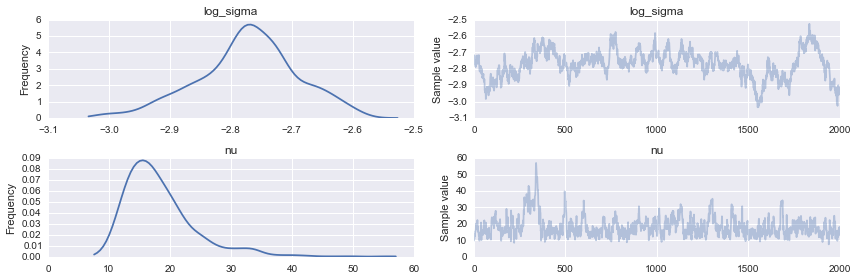

In [72]:
figsize(16, 8)
_ = pm3.traceplot(trace, sv_model.vars[:-1])

In [158]:
pm3.stats.summary(trace, sv_model.vars[:-1])


log_sigma:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -2.772           0.083            0.008            [-2.938, -2.612]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.951         -2.820         -2.769         -2.722         -2.618


nu:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  18.383           6.100            0.469            [9.426, 31.342]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  10.797         14.277         16.989         20.726         33.967



In [82]:
d_trace_s = pd.DataFrame(data=trace[s][::10]).T.set_index(s_diff_price.index)

In [87]:
cols_desc = d_trace_s.describe().index
cols_desc

Index([u'count', u'mean', u'std', u'min', u'25%', u'50%', u'75%', u'max'], dtype='object')

In [88]:
d_trace_s.describe().T.rename(columns={c: "s_%s" % c for c in cols_desc}).describe()

,s_count,s_mean,s_std,s_min,s_25%,s_50%,s_75%,s_max
count,200,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,3594,-4.720995,0.479351,-5.758273,-5.073659,-4.801803,-4.423800,-2.960117
std,0,0.020032,0.012683,0.086824,0.022993,0.024013,0.029623,0.126826
min,3594,-4.790637,0.441315,-6.098403,-5.147093,-4.862259,-4.531506,-3.310073
25%,3594,-4.733431,0.470858,-5.815427,-5.089445,-4.816880,-4.442223,-3.053585
50%,3594,-4.719585,0.479357,-5.755007,-5.072374,-4.803711,-4.422724,-2.952970
75%,3594,-4.707285,0.488373,-5.693448,-5.058341,-4.784844,-4.402315,-2.867110
max,3594,-4.671260,0.512074,-5.518128,-5.020776,-4.739999,-4.326210,-2.499279


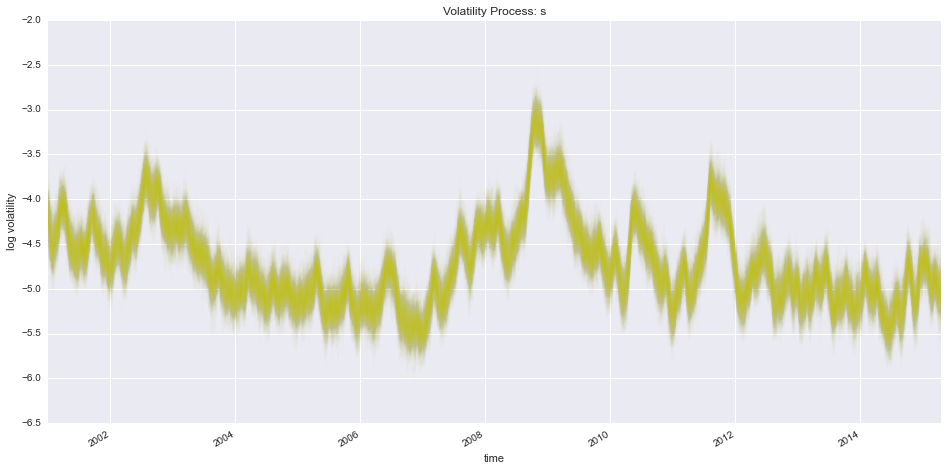

In [126]:
_ = d_trace_s.plot(figsize(16, 8), color="y", alpha=.01, legend=False, title="Volatility Process: %s" % str(s))
_ = xlabel('time')
_ = ylabel('log volatility')


In [124]:
sd_est = np.exp(d_trace_s)

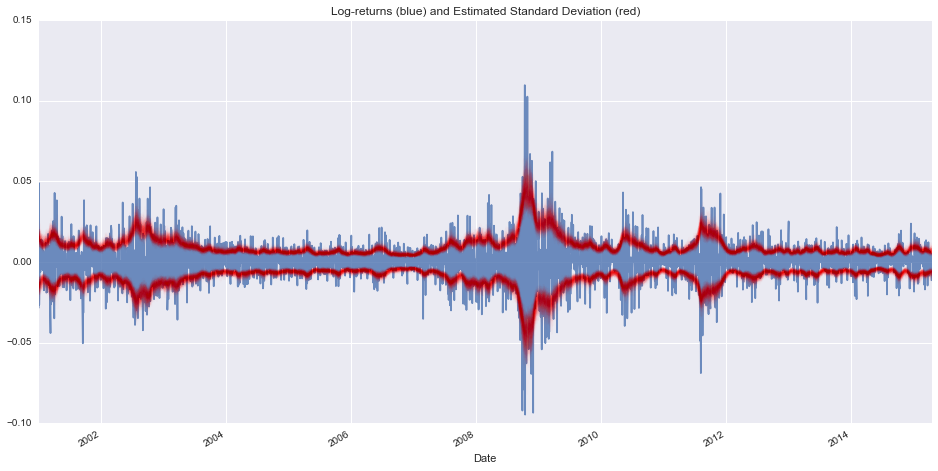

In [127]:
fig, ax = plt.subplots()
ax.set_title("Log-returns (blue) and Estimated Standard Deviation (red)")
s_diff_price.plot(ax=ax, alpha=0.8)
sd_est.plot(ax=ax, color="r", alpha=.01, legend=False)
(-sd_est).plot(ax=ax, color="r", alpha=.01, legend=False)


In [128]:
# compare with basic rolling std measure

In [139]:
sd_roll_10 = pd.rolling_std(s_diff_price, 10)
sd_roll_50 = pd.rolling_std(s_diff_price, 50)

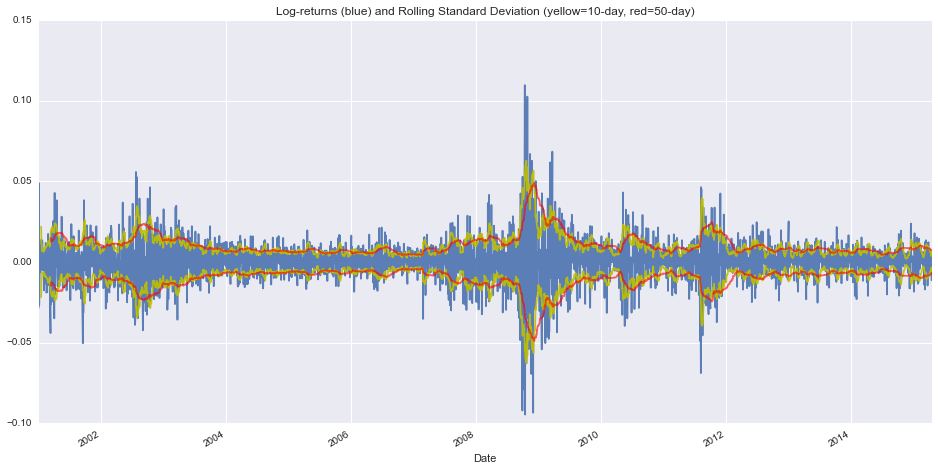

In [155]:
fig, ax = plt.subplots()
ax.set_title("Log-returns (blue) and Rolling Standard Deviation (yellow=10-day, red=50-day)")
s_diff_price.plot(ax=ax, alpha=0.9)
sd_roll_10.plot(ax=ax, color="y", alpha=0.9)
(-sd_roll_10).plot(ax=ax, color="y", alpha=0.9)
sd_roll_50.plot(ax=ax, color="r", alpha=0.6)
(-sd_roll_50).plot(ax=ax, color="r", alpha=0.6)
